# Summary <a name='summary'></a>

The following steps were made:
- [initial review](#initial_review)
- [duplicates check](#duplicate_check)
- [missing values check](#missing_values)
- [negative and zero payments check](#negative)
- [duplication of department names check](#dup_dep)
- [correct dates check](#correct_dates)
- [distribution of the number of records check](#dist_records)
- [cleaning the mess in column](#leven)

Further analysis helped figure out:
- [which department was requesting the most payments](#dep_payments)
- [which insurance company made the largest payments](#insurance_payments)

[ABC analysis was also performed to understand the monthly pattern of payments by procedure](#abc)

[ARIMA alorithm was applied to forecast payments in the following months:](#arima)
- [season and trend check](#arima_season)
- [grid search for seasonality and trend](#arima_grid)
- [forecast and validation](#arima_valid)
- [forecast vizualization](#arima_viz)

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
import itertools 
import numpy as np
from sklearn.cluster import AffinityPropagation
from Levenshtein import distance
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
warnings.filterwarnings('ignore')

In [2]:
full_link = 'https://docs.google.com/spreadsheets/d/12o1iofQx6V-UhInjUjLjpKxx3Z8ve8EGxnQtzNioIv4/edit?usp=sharing'
sheet_key = '12o1iofQx6V-UhInjUjLjpKxx3Z8ve8EGxnQtzNioIv4'
sheet_name = 'Sheet1'
link = f'https://docs.google.com/spreadsheet/ccc?key={sheet_key}&output=xlsx'
raw_df = pd.read_excel(link, sheet_name=sheet_name)
print(raw_df.head())

    MONTH SERVICE_CATEGORY CLAIM_SPECIALTY    PAYER  PAID_AMOUNT
0  201801     AncillaryFFS             NaN  Payer F         4281
1  201801     AncillaryFFS             NaN  Payer H         2221
2  201801     AncillaryFFS             NaN  Payer O         3937
3  201801     AncillaryFFS             NaN  Payer W          268
4  201801     AncillaryFFS             ACH  Payer W          151


Initial review: <a name='initial_review'></a>
###### [Back to top](#summary)

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52152 entries, 0 to 52151
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MONTH             52152 non-null  int64 
 1   SERVICE_CATEGORY  52152 non-null  object
 2   CLAIM_SPECIALTY   51901 non-null  object
 3   PAYER             52152 non-null  object
 4   PAID_AMOUNT       52152 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.0+ MB


Check for duplicates: <a name='duplicate_check'></a>
###### [Back to top](#summary)

In [4]:
duplicate_rows_df = raw_df[raw_df.duplicated()]
assert len(duplicate_rows_df) == 0, 'Where are duplicates!'

Missing values: 
<a name='missing_values'></a>
###### [Back to top](#summary)

In [5]:
raw_df.isnull().sum()

MONTH                 0
SERVICE_CATEGORY      0
CLAIM_SPECIALTY     251
PAYER                 0
PAID_AMOUNT           0
dtype: int64

In [6]:
print(str(round((raw_df['CLAIM_SPECIALTY'].isnull().sum() / (len(raw_df['CLAIM_SPECIALTY']))) * 100, 1)) + '%')

0.5%


Approximately 0.5% of all values in the field 'CLAIM_SPECIALTY' are missing.

We also see that the 'AncillaryFFS' department was the leader in the number of blank values in the 'CLAIM_SPECIALTY' field:

In [7]:
missing_claim_specialty = raw_df[raw_df['CLAIM_SPECIALTY'].isna() == True]\
    .groupby('SERVICE_CATEGORY')['PAID_AMOUNT'].count().reset_index().rename(columns={'PAID_AMOUNT': 'MISSING_RECORDS'})\
        .sort_values(by=['MISSING_RECORDS'], ascending=False)
missing_claim_specialty.style.hide()

SERVICE_CATEGORY,MISSING_RECORDS
AncillaryFFS,64
SNFServices,51
PCPFFS,31
OutpatientServices,21
ERServices,20
InpatientServices,19
SpecialistsFFS,18
SpecialistFFS,15
ASCServices,12


The most expensive blanks were made by the 'PCPFFS' and 'AncillaryFFS' department:

In [8]:
missing_claim_cost = raw_df[raw_df['CLAIM_SPECIALTY'].isna() == True]\
    .groupby('SERVICE_CATEGORY')['PAID_AMOUNT'].sum().reset_index().rename(columns={'PAID_AMOUNT': 'PAID_FOR_MISSING_RECORDS'})\
        .sort_values(by='PAID_FOR_MISSING_RECORDS', ascending=False)
missing_claim_cost.style.hide()

SERVICE_CATEGORY,PAID_FOR_MISSING_RECORDS
PCPFFS,213166
AncillaryFFS,203063
SNFServices,78389
InpatientServices,62240
SpecialistFFS,61337
ERServices,30491
SpecialistsFFS,23647
OutpatientServices,22233
ASCServices,9909


Let's check out the negative and zero payments - which department was most likely to make these mistakes? \
And they are also 'PCPFFS' and 'AncillaryFFS': 
<a name='negative'></a>
###### [Back to top](#summary)

In [9]:
negative_paid_amount = raw_df[raw_df['PAID_AMOUNT'] <= 0].groupby('SERVICE_CATEGORY')['PAID_AMOUNT'].count()\
    .reset_index().rename(columns={'PAID_AMOUNT': 'COUNT_NEGATIVE_PAYENTS'})\
        .sort_values(by='COUNT_NEGATIVE_PAYENTS', ascending=False)
negative_paid_amount.style.hide()

SERVICE_CATEGORY,COUNT_NEGATIVE_PAYENTS
AncillaryFFS,1545
PCPEncounter,1179
SpecialistsFFS,511
OutpatientServices,259
InpatientServices,211
ERServices,183
SNFServices,135
ASCServices,83
SpecialistFFS,61
PCPFFS,5


Let's delete them:

In [10]:
raw_df = raw_df[raw_df['PAID_AMOUNT'] > 0]

Let's look closer to 'SERVICE_CATEGORY'. 
As we can see, we have duplicates by departments name.\
It is very likely that 'SpecialistFFS' and 'SpecialistsFFS' belong to the same department:
<a name='dup_dep'></a>
###### [Back to top](#summary)

In [11]:
sorted(raw_df['SERVICE_CATEGORY'].unique())

['ASCServices',
 'AncillaryFFS',
 'ERServices',
 'InpatientServices',
 'OutpatientServices',
 'PCPEncounter',
 'PCPFFS',
 'SNFServices',
 'SpecialistFFS',
 'SpecialistsFFS']

Let's replace it:

In [12]:
raw_df['SERVICE_CATEGORY'] = raw_df['SERVICE_CATEGORY'].replace('SpecialistsFFS', 'SpecialistFFS')

Let's look closer to column 'MONTH' - check for correct month and year:
<a name='correct_dates'></a>
###### [Back to top](#summary)


In [13]:
raw_df['MONTH'].astype(str).str[:4].unique(), raw_df['MONTH'].astype(str).str[4:].unique()

(array(['2018', '2019', '2020'], dtype=object),
 array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
        '12', '00'], dtype=object))

and noting that the month '00' is present, delete it:

In [14]:
raw_df = raw_df[raw_df['MONTH'].astype(str).str[4:] != '00']

Let's create new column 'DATE':

In [15]:
raw_df['DATE'] = pd.to_datetime(raw_df['MONTH'], format='%Y%m', errors='coerce').dt.date.dropna()

Let's see how the number of records is distributed by months:
<a name='dist_records'></a>
###### [Back to top](#summary)

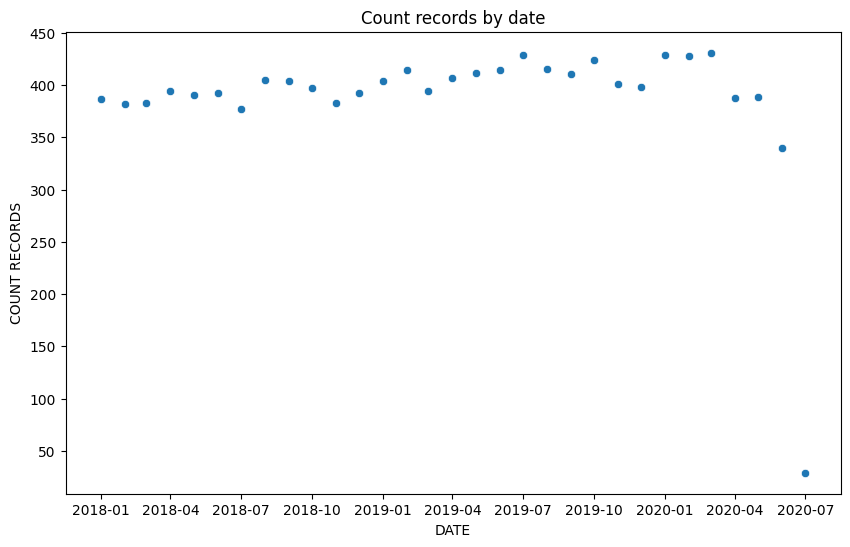

In [16]:
count_records_by_month = raw_df.groupby(['DATE'])['CLAIM_SPECIALTY'].agg('nunique').reset_index()
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DATE', y='CLAIM_SPECIALTY', data=count_records_by_month)
plt.title('Count records by date')
plt.ylabel('COUNT RECORDS')
plt.show()

In [17]:
print(str(round(raw_df[raw_df['MONTH'].isin([202007, 202006])]['PAID_AMOUNT'].sum() / raw_df['PAID_AMOUNT'].sum() * 100, 2)) + '%')

1.57%


Last month's data is trimmed (probably 202006 is trimmed too). Since they represent less than 1.57% of all payments, we will delete them:

In [18]:
raw_df = raw_df[~raw_df['MONTH'].isin([202007, 202006])]

We see that there is missing data for department 'PCPEncounter' for the first month of 2018 and for the entire year 2020.\
They've been lost or this department has simply stopped working since 2020:

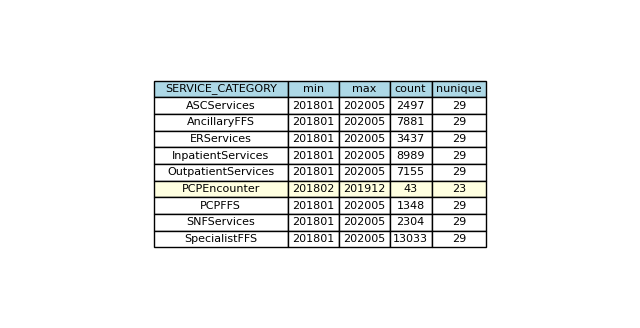

In [19]:
statistics_table = raw_df.groupby('SERVICE_CATEGORY')['MONTH'].agg(['min', 'max', 'count', 'nunique']).reset_index()
colors = ['background-color: lightyellow' if statistics_table['SERVICE_CATEGORY'][i] == 'PCPEncounter' else '' for i in range(len(statistics_table))]
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
tbl = ax.table(cellText=statistics_table.values, colLabels=statistics_table.columns, cellLoc='center', loc='center', colColours=['lightblue']*len(statistics_table.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.auto_set_column_width(col=list(range(len(statistics_table.columns))))
for i in range(0, len(statistics_table)):
    if statistics_table['SERVICE_CATEGORY'][i] == 'PCPEncounter':
        for j in range(len(statistics_table.columns)):
            tbl[(i+1, j)].set_facecolor('lightyellow')
plt.show()

In [20]:
print(str(round(raw_df[raw_df['SERVICE_CATEGORY'] == 'PCPEncounter']['PAID_AMOUNT'].sum() / (raw_df['PAID_AMOUNT'].sum()) * 100, 2)) + '%')

0.01%


Since the total expences for this department are only 0.01% of the total expences, let's delete these records.

In [21]:
raw_df = raw_df[raw_df['SERVICE_CATEGORY'] != 'PCPEncounter']

Let's take a look which department requested the biggest payouts: it is 'InpatientServices' department:
<a name='dep_payments'></a>
###### [Back to top](#summary)

<Figure size 2000x1600 with 0 Axes>

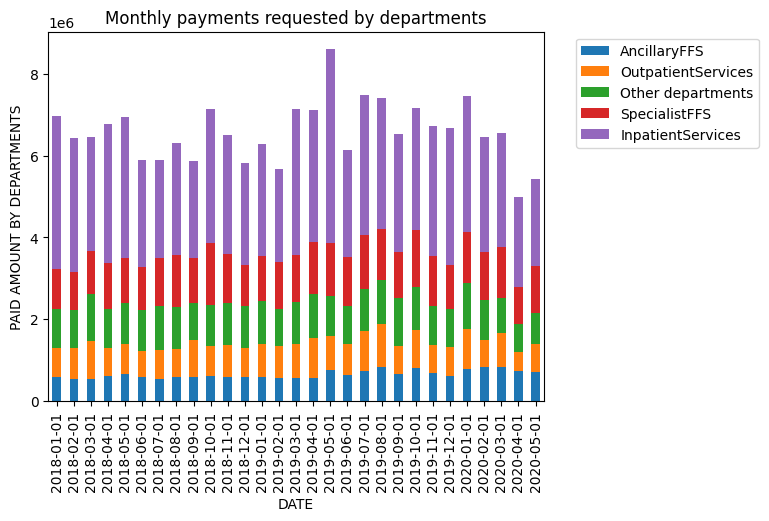

In [22]:
payments_by_dep = raw_df.copy()
allowed_values = ['InpatientServices', 'SpecialistFFS', 'OutpatientServices', 'AncillaryFFS']
payments_by_dep['SERVICE_CATEGORY_CUT'] = payments_by_dep['SERVICE_CATEGORY'].apply(lambda x: x if x in allowed_values else 'Other departments')
paid_by_dep = payments_by_dep.groupby(['DATE', 'SERVICE_CATEGORY_CUT'])['PAID_AMOUNT'].sum().reset_index().sort_values(by=['DATE', 'PAID_AMOUNT'], ascending=[True, False])
pivot_df = paid_by_dep.pivot_table(index='DATE', columns='SERVICE_CATEGORY_CUT', values='PAID_AMOUNT', aggfunc='sum', fill_value=0)
pivot_df = pivot_df.loc[:, pivot_df.sum().sort_values().index]

plt.figure(figsize=(20, 16))
pivot_df.plot(kind='bar', stacked=True)
plt.title('Monthly payments requested by departments')
plt.xlabel('DATE')
plt.ylabel('PAID AMOUNT BY DEPARTMENTS')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Let's look at field 'PAYER' and notice, that payer 'Payer UL' appears only since 2018-11-01 (it was a break in its payments or it was just new payer):
<a name='insurance_payments'></a>
###### [Back to top](#summary)

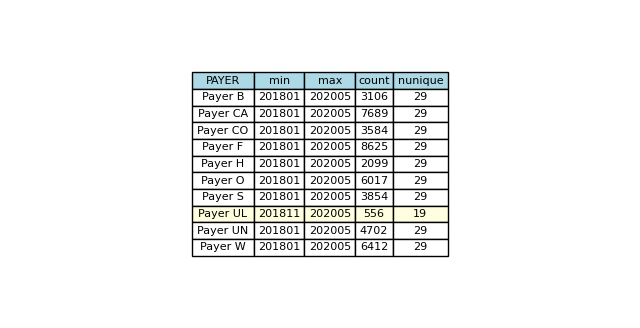

In [23]:
info_about_payers = raw_df.groupby('PAYER')['MONTH'].agg(['min', 'max', 'count', 'nunique']).reset_index()
colors = ['background-color: lightyellow' if info_about_payers['PAYER'][i] == 'Payer UL' else '' for i in range(len(info_about_payers))]
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
tbl = ax.table(cellText=info_about_payers.values, colLabels=info_about_payers.columns, cellLoc='center', loc='center', colColours=['lightblue']*len(info_about_payers.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.auto_set_column_width(col=list(range(len(info_about_payers.columns)))) 
for i in range(0, len(info_about_payers)):
    if info_about_payers['PAYER'][i] == 'Payer UL':
        for j in range(len(statistics_table.columns)):
            tbl[(i+1, j)].set_facecolor('lightyellow')
plt.show()

The insurance company that paid every month the most was 'Payer F'.

<Figure size 2000x1600 with 0 Axes>

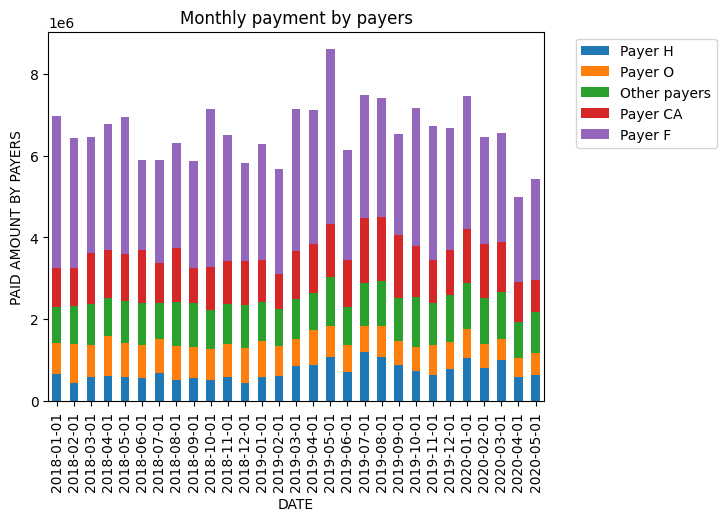

In [24]:
payments_by_payer = raw_df.groupby(['DATE', 'PAYER'])['PAID_AMOUNT'].sum().reset_index()
allowed_values = ['Payer F', 'Payer CA', 'Payer H', 'Payer O']
payments_by_payer['PAYER_CUT'] = payments_by_payer['PAYER'].apply(lambda x: x if x in allowed_values else 'Other payers')
paid_by_payer = payments_by_payer.groupby(['DATE', 'PAYER_CUT'])['PAID_AMOUNT'].sum().reset_index().sort_values(by=['DATE', 'PAID_AMOUNT'], ascending=[True, False])
pivot_df = paid_by_payer.pivot_table(index='DATE', columns='PAYER_CUT', values='PAID_AMOUNT', aggfunc='sum', fill_value=0)
pivot_df = pivot_df.loc[:, pivot_df.sum().sort_values().index]
plt.figure(figsize=(20, 16))
pivot_df.plot(kind='bar', stacked=True)
plt.title('Monthly payment by payers')
plt.xlabel('DATE')
plt.ylabel('PAID AMOUNT BY PAYERS')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Let's show that it is theoretically possible to get rid of the mess in column 'CLAIM_SPECIALTY'.\
This may reduce the number of unique values in the column 'CLAIM_SPECIALTY', which may be useful for further analysis.
We apply clustering based on Levenshtein distance to find similar groups of words.
<a name='leven'></a>
###### [Back to top](#summary)

In [25]:
raw_df['CLAIM_SPECIALTY'] = raw_df['CLAIM_SPECIALTY'].fillna('')
raw_df['CLAIM_SPECIALTY_cleaned'] = raw_df['CLAIM_SPECIALTY'].str.lower()
bad_symbols = ['-', '&', '/', 'error', 'unknown', 'unknown md', '(', ')', 'no specialty required', '\t', ',', ' and ', 'not mapped', 'notprovided', 'with']
for symbol in bad_symbols:
    raw_df['CLAIM_SPECIALTY_cleaned'] = raw_df['CLAIM_SPECIALTY_cleaned'].str.replace(symbol, ' ')
raw_df['CLAIM_SPECIALTY_cleaned'] = raw_df['CLAIM_SPECIALTY_cleaned'].apply(lambda x: re.sub(' {2,}', ' ', x))
claims = raw_df['CLAIM_SPECIALTY_cleaned'].unique()
words = np.asarray(claims) 
lev_similarity = (-1 * np.array([[distance(w1, w2) for w1 in words] for w2 in words])).astype(float)
pair_dict = {}
affprop = AffinityPropagation(affinity='precomputed', damping=0.5)
affprop.fit(lev_similarity)
for cluster_id in np.unique(affprop.labels_):
    parent = words[affprop.cluster_centers_indices_[cluster_id]]
    child = np.unique(words[np.nonzero(affprop.labels_ == cluster_id)])
    for word in child:
        pair_dict[word] = parent
raw_df['NEW_CLAIM'] = raw_df['CLAIM_SPECIALTY_cleaned'].apply(lambda x: pair_dict[x])
claim_df = raw_df.groupby(['NEW_CLAIM','CLAIM_SPECIALTY_cleaned']).size().reset_index()
del claim_df[0] 
claim_df.head(15).style.hide()

NEW_CLAIM,CLAIM_SPECIALTY_cleaned
acute care hospital,acute care hospital
acute care hospital,acute short term hospital
acute care hospital,general acute care hospital
acute care hospital,health care professionals other
acute care hospital,long term care hosp
acute care hospital,long term care hospital
acute care hospital,psychiatric hospital
acute care hospital,spc fcly ca hospital
acute care hospital,special ty hospital
advanced heart failure transplant cardiology,advanced heart failure transplant cardiology


After the very first iteration, the unique count decreased:

In [26]:
raw_df['NEW_CLAIM'].nunique(), raw_df['CLAIM_SPECIALTY_cleaned'].nunique()

(109, 730)

Let's do an ABC analysis to see which medical services make up the majority of the requested payments.
- The payment core for each month contains between 45 and 62 procedures, 22 of which are common to each month.
- The percentage of intersections with the core ranges from 35.5% to 48.9%.
<a name='abc'></a>
###### [Back to top](#summary)

In [27]:
def abc_analyze(group):
    cumulative_sum = group['PAID_AMOUNT'].cumsum()
    total_sum = cumulative_sum.max()
    group['CUM_PERCENT'] = cumulative_sum / total_sum * 100
    group['CATEGORY'] = pd.cut(group['CUM_PERCENT'], bins=[0, 90, 95, 100], labels=['A', 'B', 'C'])
    return group

group_by_claim = raw_df.groupby(['MONTH', 'CLAIM_SPECIALTY_cleaned'])['PAID_AMOUNT'].sum().reset_index().sort_values(by=['MONTH', 'PAID_AMOUNT'], ascending=[True, False])
group_by_month = group_by_claim.groupby('MONTH').apply(abc_analyze).reset_index(drop=True)
a_groups_by_month = []
for month in group_by_month['MONTH'].unique():
    a_groups_by_month.append(group_by_month[(group_by_month['MONTH'] == month) & (group_by_month['CATEGORY'] == 'A')]['CLAIM_SPECIALTY_cleaned'].unique())
common_elements = set.intersection(*[{x for lst in sub for x in lst} for sub in a_groups_by_month])
common_elements_length = len(common_elements)
ratios = [common_elements_length / len(sublist) for sublist in a_groups_by_month] 
min_quantity = min([len(item) for item in a_groups_by_month])
max_quantity = max([len(item) for item in a_groups_by_month])

In [28]:
print('Min number of procedures in A-group: ' + str(min_quantity))
print('Max number of procedures in A-group: ' + str(max_quantity))
print('Number of common procedures: ' + str(common_elements_length))
print('The percentage of intersections with the core ranges from {} to {}'.format(str(round(min(ratios) * 100, 1)) + '%', str(round(max(ratios) * 100, 1)) + '%'))

Min number of procedures in A-group: 45
Max number of procedures in A-group: 62
Number of common procedures: 22
The percentage of intersections with the core ranges from 35.5% to 48.9%


Payments forecast with ARIMA:
<a name='arima'></a>
###### [Back to top](#summary)

We have both stationary and non-stationary series:

In [29]:
payment_by_category = raw_df.groupby(['DATE', 'SERVICE_CATEGORY'])['PAID_AMOUNT'].sum().reset_index()
payment_by_category.set_index('DATE', inplace=True)
for category in payment_by_category['SERVICE_CATEGORY'].unique():
    partial_df = payment_by_category[payment_by_category['SERVICE_CATEGORY'] == category][['PAID_AMOUNT']]
    p_value = adfuller(partial_df)[1]
    print(category, round(p_value, 4))

ASCServices 0.3323
AncillaryFFS 0.1135
ERServices 0.1072
InpatientServices 0.0005
OutpatientServices 0.0
PCPFFS 0.002
SNFServices 0.0
SpecialistFFS 0.0002


First visualize the payments by department.\
The key assumption is that each department has its own seasonality, so we will predict future payments separately for each department.

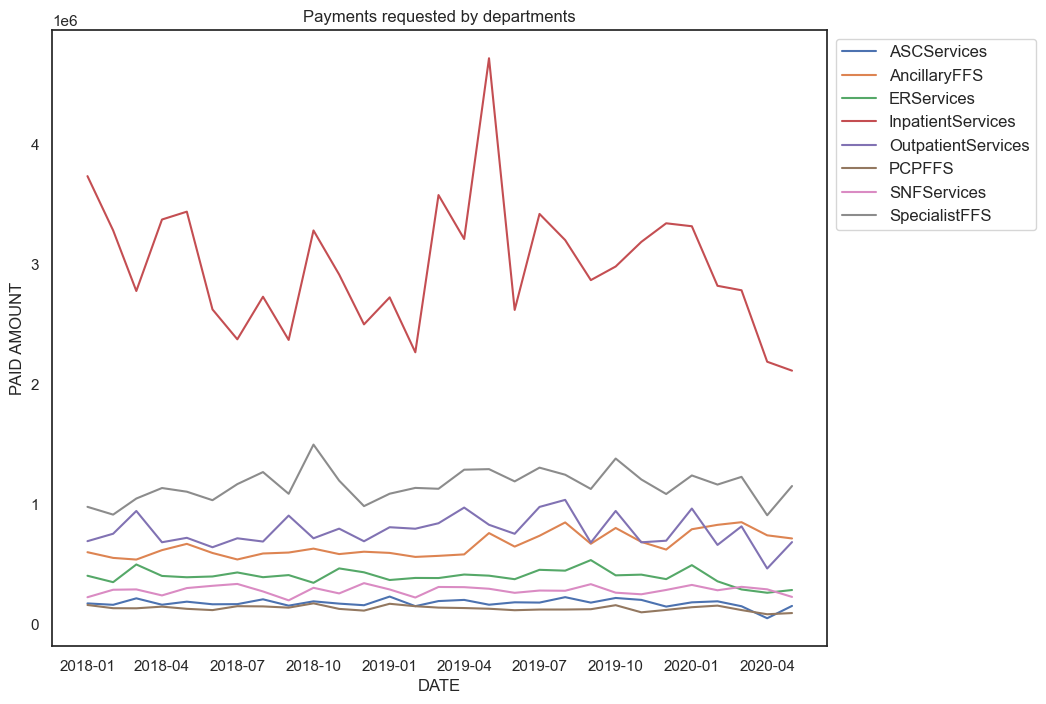

In [30]:
sns.set(style='white')
plt.figure(figsize=(10, 8))
sns.lineplot(x='DATE', y='PAID_AMOUNT', hue='SERVICE_CATEGORY', legend='brief', data=payment_by_category)
plt.title('Payments requested by departments')
plt.xlabel('DATE')
plt.ylabel('PAID AMOUNT')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='medium')
plt.show()

The plot below clearly shows that the payments are unstable along with its obvious seasonality:
<a name='arima_season'></a>
###### [Back to top](#summary)

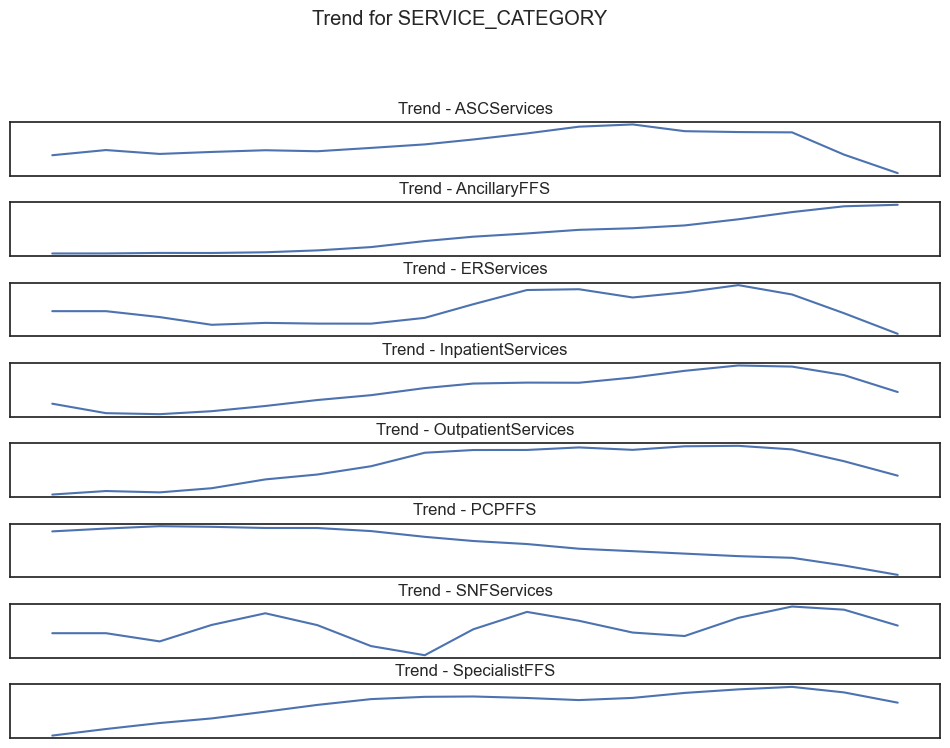

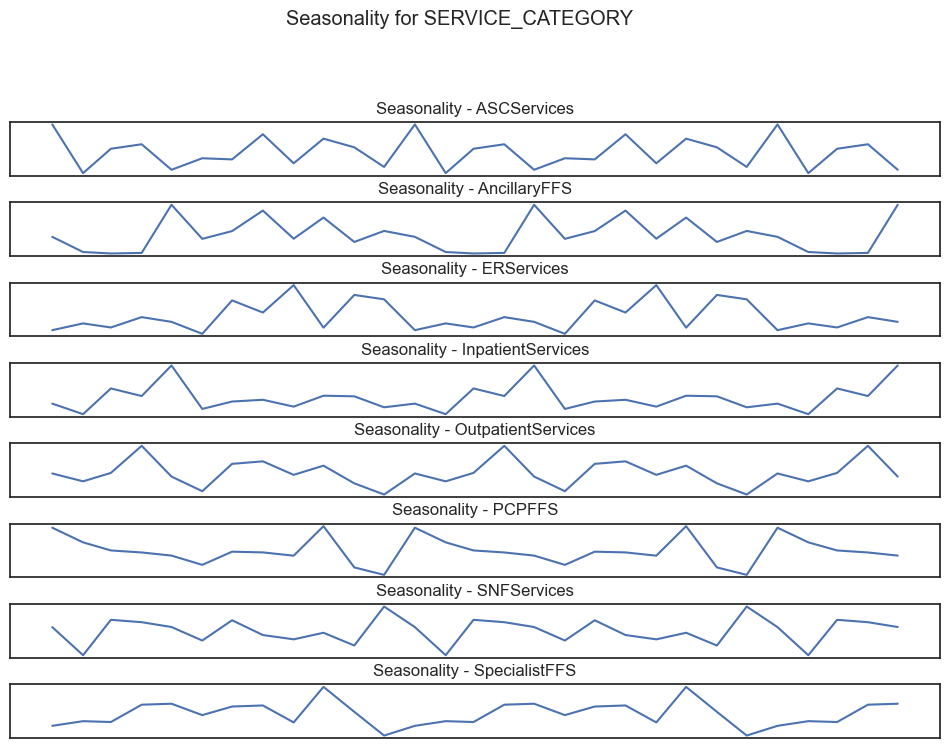

In [31]:
trend_dict, season_dict = {}, {}
for ts in payment_by_category['SERVICE_CATEGORY'].unique():
    decomposition = seasonal_decompose(payment_by_category[payment_by_category['SERVICE_CATEGORY'] == ts]['PAID_AMOUNT'].dropna(), period=12)
    trend_dict[ts] = decomposition.trend
    season_dict[ts] = decomposition.seasonal

trend_df, season_df = pd.DataFrame(trend_dict), pd.DataFrame(season_dict)
plt.figure(figsize=(12, 8))
plt.suptitle('Trend for SERVICE_CATEGORY', y=1.02)

for i, column in enumerate(trend_df.columns):
    plt.subplot(len(trend_df.columns), 1, i+1)
    plt.plot(trend_df.index, trend_df[column])
    plt.title(f'Trend - {column}')
    plt.xticks([])
    plt.yticks([])

plt.subplots_adjust(hspace=0.5)
plt.show()

plt.figure(figsize=(12, 8))
plt.suptitle('Seasonality for SERVICE_CATEGORY', y=1.02)

for i, column in enumerate(season_df.columns):
    plt.subplot(len(season_df.columns), 1, i+1)
    plt.plot(season_df.index, season_df[column])
    plt.title(f'Seasonality - {column}')
    plt.xticks([])
    plt.yticks([])

plt.subplots_adjust(hspace=0.5)
plt.show()

Let's apply one of the most commonly used method for time-series forecasting - ARIMA (Autoregressive Integrated Moving Average).\
ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.

In [32]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Parameter combinations for Seasonal ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Parameter combinations for Seasonal ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We will use a grid search to find the optimal set of parameters that gives the best performance for our model (based on lowest AIC value):
<a name='arima_grid'></a>
###### [Back to top](#summary)

In [33]:
category_aic = {}
for category in payment_by_category['SERVICE_CATEGORY'].unique():
    payment_by_category_department = payment_by_category[payment_by_category['SERVICE_CATEGORY'] == category]['PAID_AMOUNT']
    res = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(payment_by_category_department,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_invertibility=False)
            results = mod.fit()
            res.append((param, param_seasonal, results.aic))
    category_aic[category] = res
parameters = {key: min(values, key=lambda x: x[2]) for key, values in category_aic.items()}
parameters

{'ASCServices': ((0, 1, 0), (0, 1, 1, 12), 398.99448164220604),
 'AncillaryFFS': ((0, 1, 0), (0, 1, 1, 12), 417.27235668724956),
 'ERServices': ((0, 1, 0), (1, 1, 0, 12), 407.1020211242334),
 'InpatientServices': ((1, 1, 0), (0, 1, 1, 12), 486.89467104824087),
 'OutpatientServices': ((1, 1, 0), (0, 1, 1, 12), 441.80481436035217),
 'PCPFFS': ((1, 1, 0), (0, 1, 0, 12), 365.5423626741807),
 'SNFServices': ((0, 1, 0), (0, 1, 1, 12), 403.7943715786714),
 'SpecialistFFS': ((1, 1, 0), (0, 1, 1, 12), 429.01605886278026)}

Let's fit the model for each department to investigate any unusual behavior and make forecasts validating:
<a name='arima_valid'></a>
###### [Back to top](#summary)

ASCServices ((0, 1, 0), (0, 1, 1, 12), 398.99448164220604)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6624      0.661     -1.003      0.316      -1.957       0.632
sigma2      3.834e+09   1.74e-10   2.21e+19      0.000    3.83e+09    3.83e+09


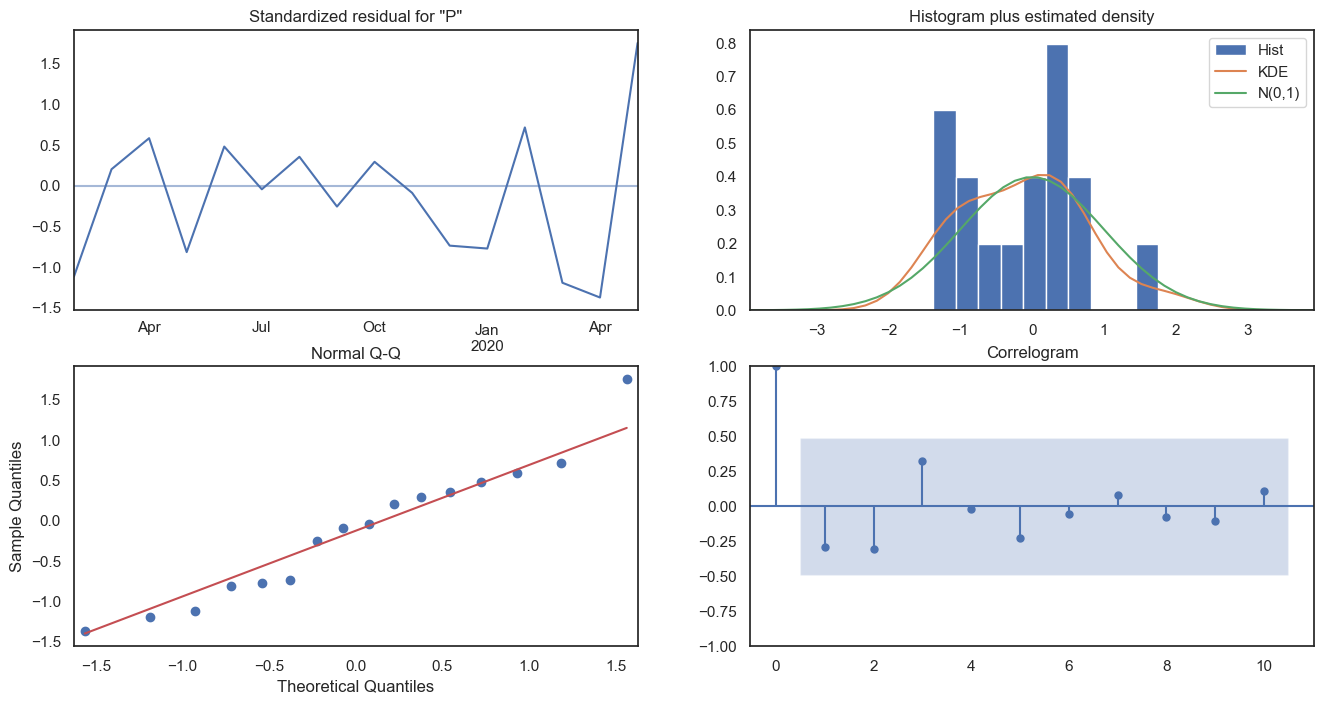

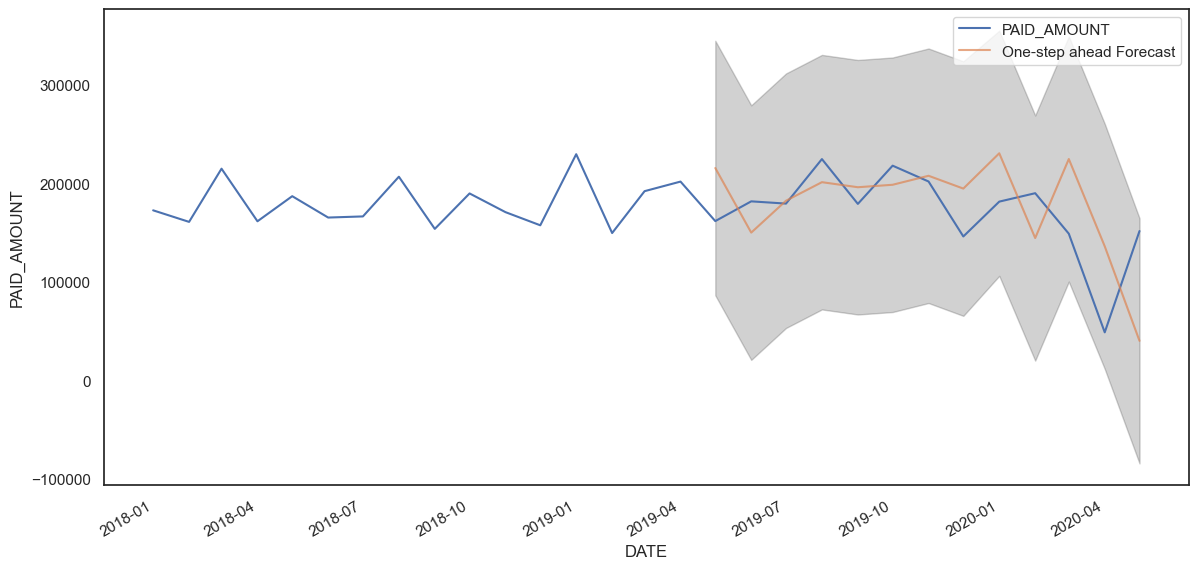

The Mean Squared Error of our forecasts is 2910072670.36
The Root Mean Squared Error of our forecasts is 53945.09


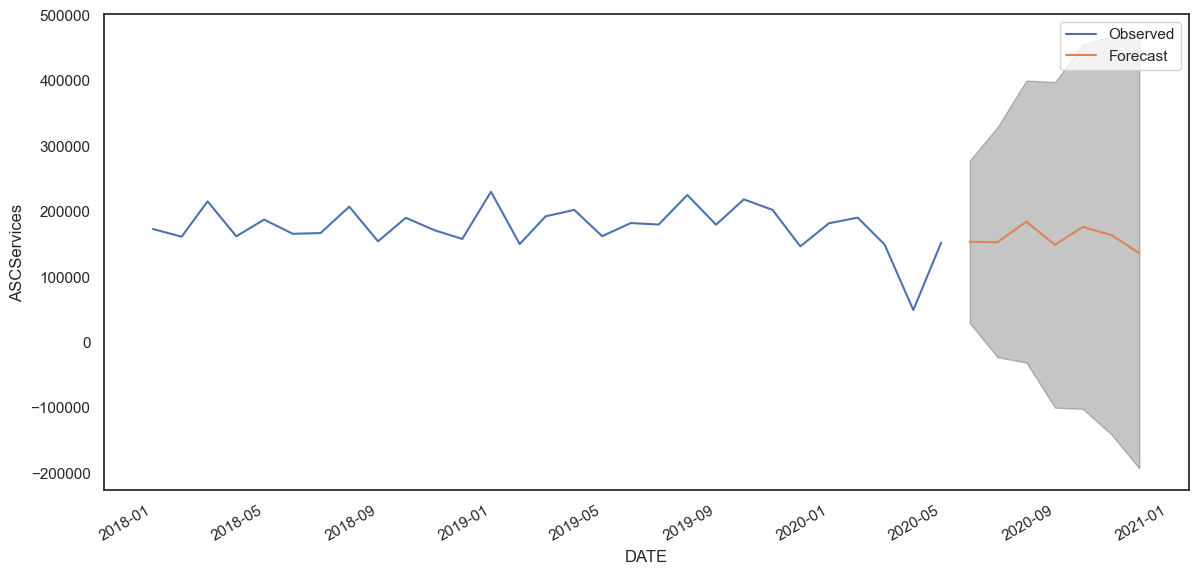

AncillaryFFS ((0, 1, 0), (0, 1, 1, 12), 417.27235668724956)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.5747      0.695     -0.827      0.408      -1.936       0.787
sigma2      1.158e+10   3.41e-11    3.4e+20      0.000    1.16e+10    1.16e+10


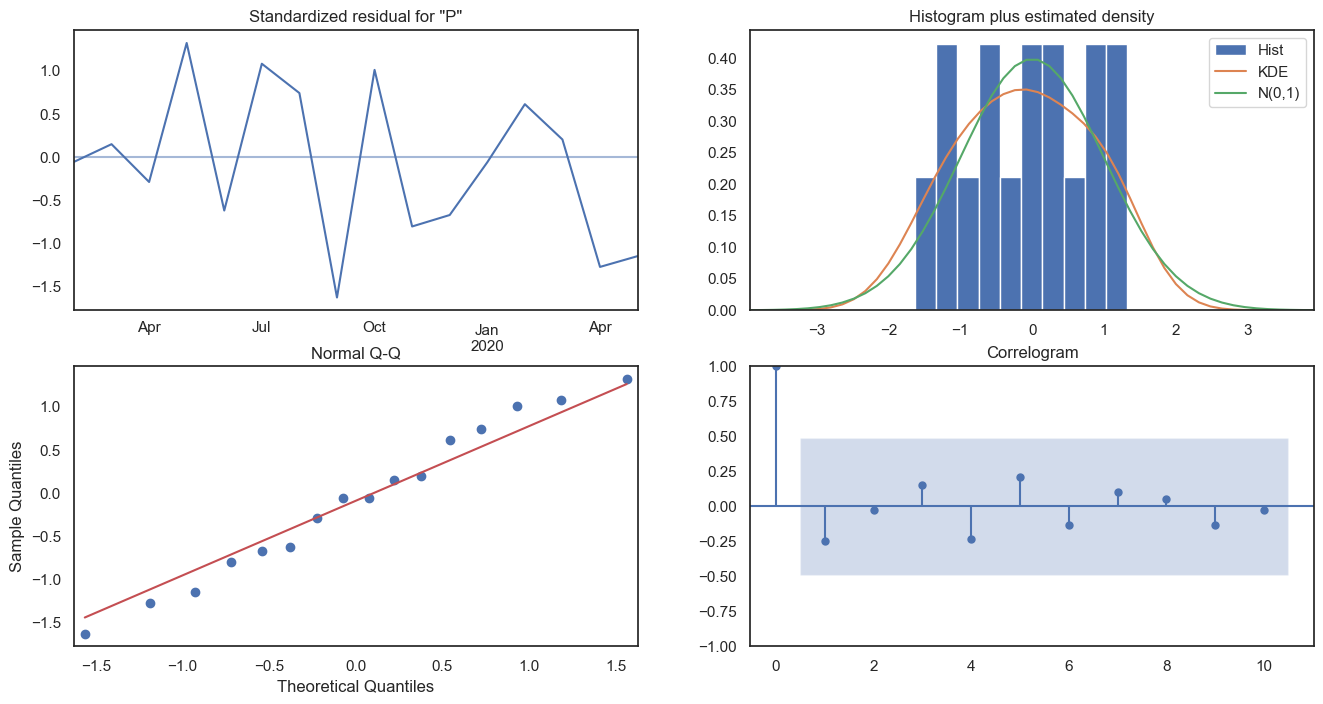

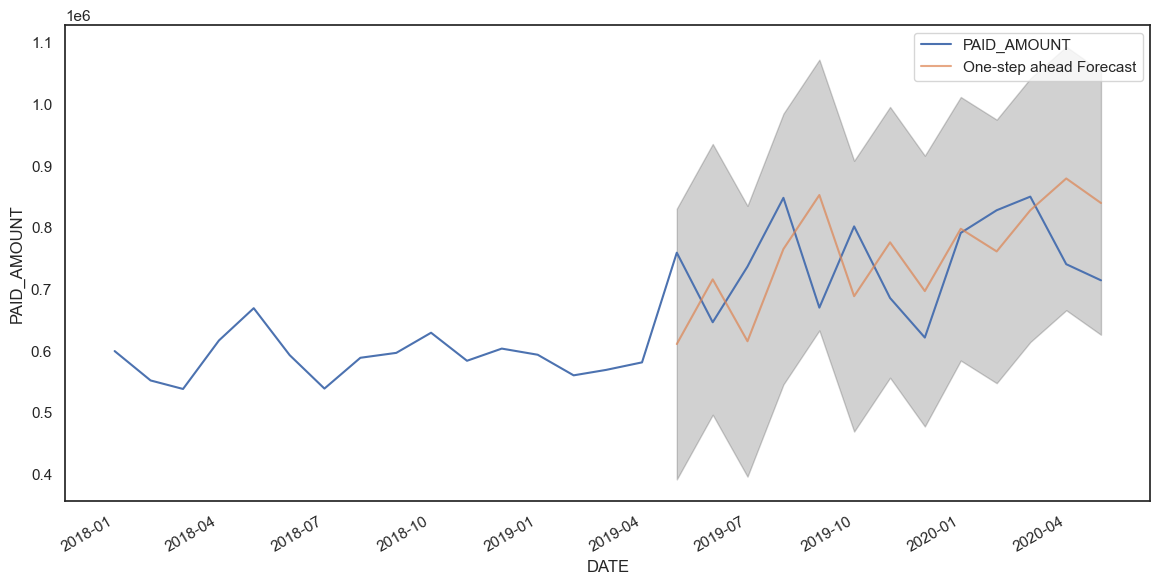

The Mean Squared Error of our forecasts is 11399657474.02
The Root Mean Squared Error of our forecasts is 106769.18


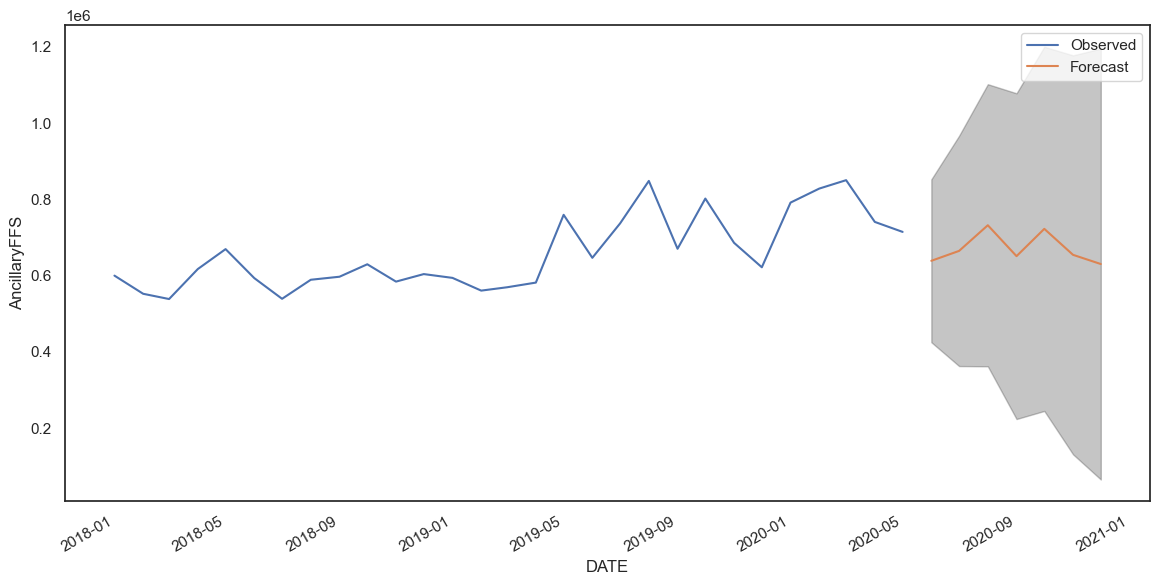

ERServices ((0, 1, 0), (1, 1, 0, 12), 407.1020211242334)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4352      0.255     -1.709      0.088      -0.935       0.064
sigma2      7.611e+09   1.95e-12    3.9e+21      0.000    7.61e+09    7.61e+09


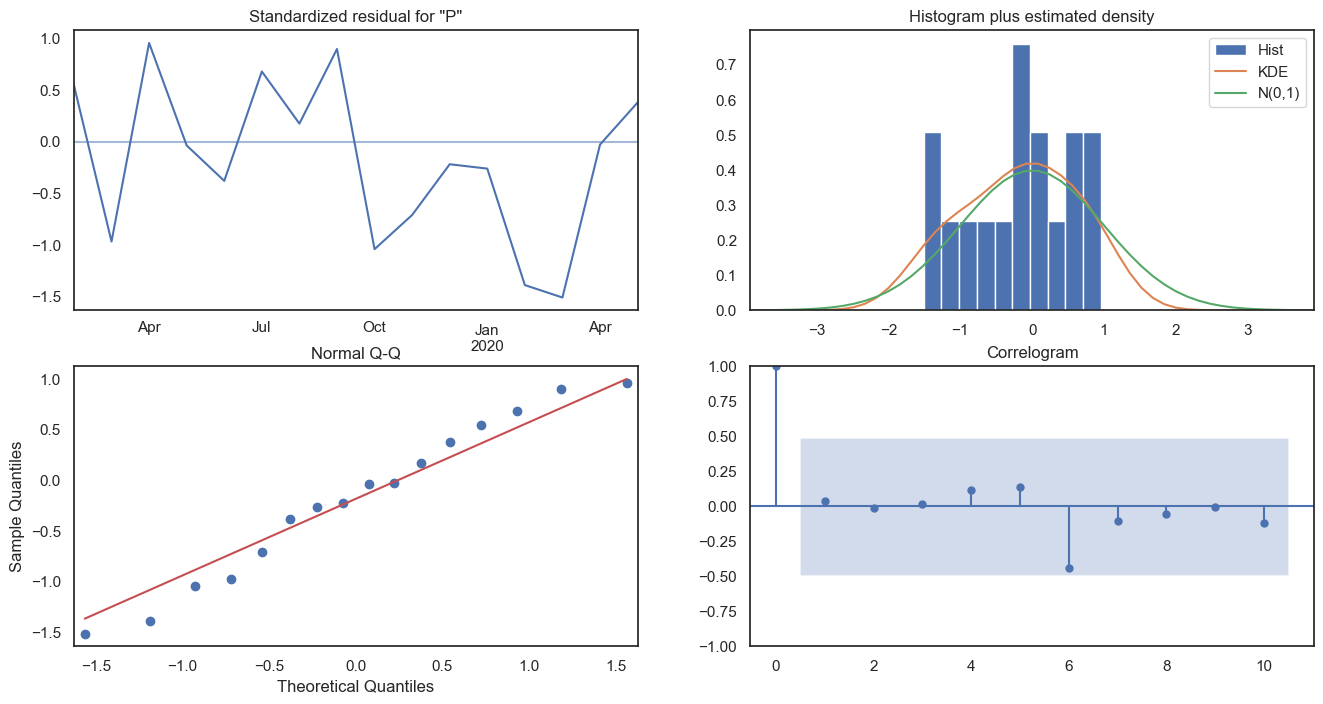

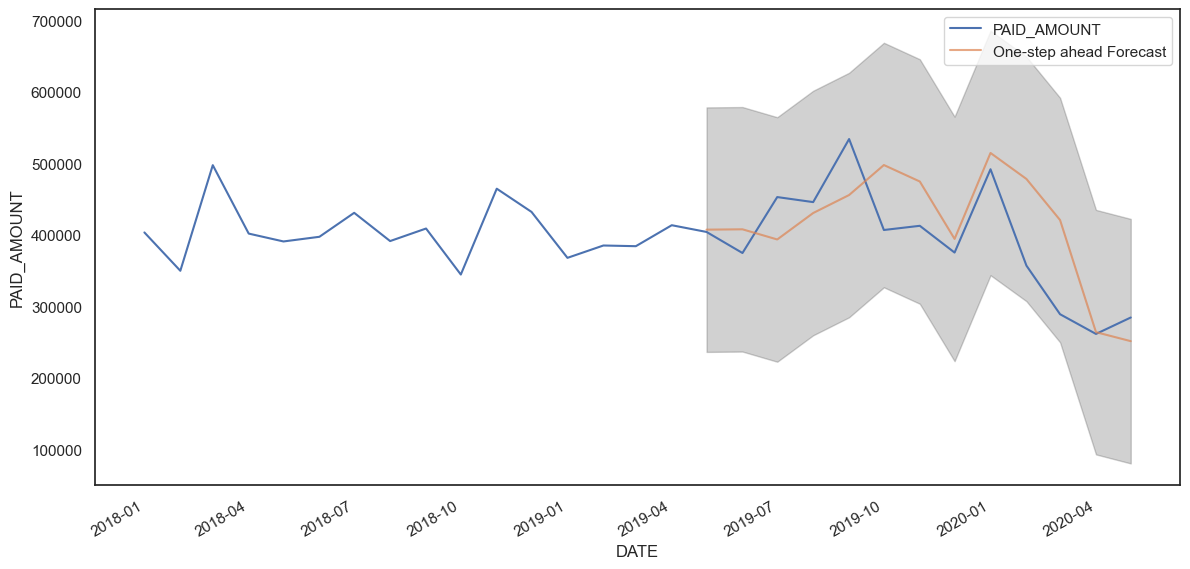

The Mean Squared Error of our forecasts is 4392657985.18
The Root Mean Squared Error of our forecasts is 66277.13


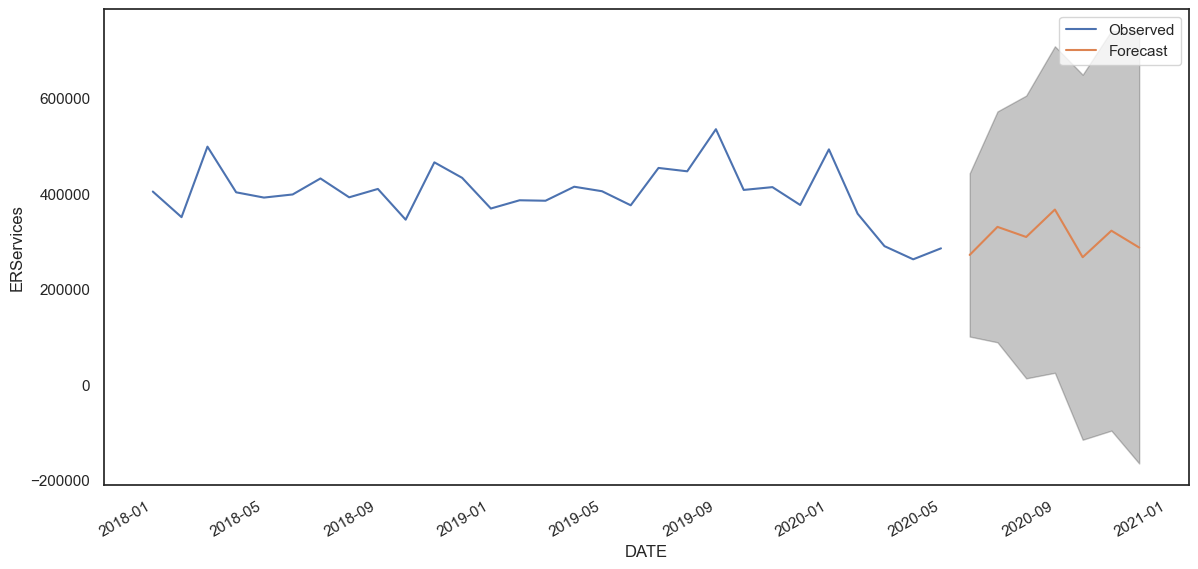

InpatientServices ((1, 1, 0), (0, 1, 1, 12), 486.89467104824087)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3527      0.316     -1.117      0.264      -0.971       0.266
ma.S.L12      -0.6051      0.581     -1.042      0.298      -1.744       0.533
sigma2      7.836e+11   2.92e-13   2.68e+24      0.000    7.84e+11    7.84e+11


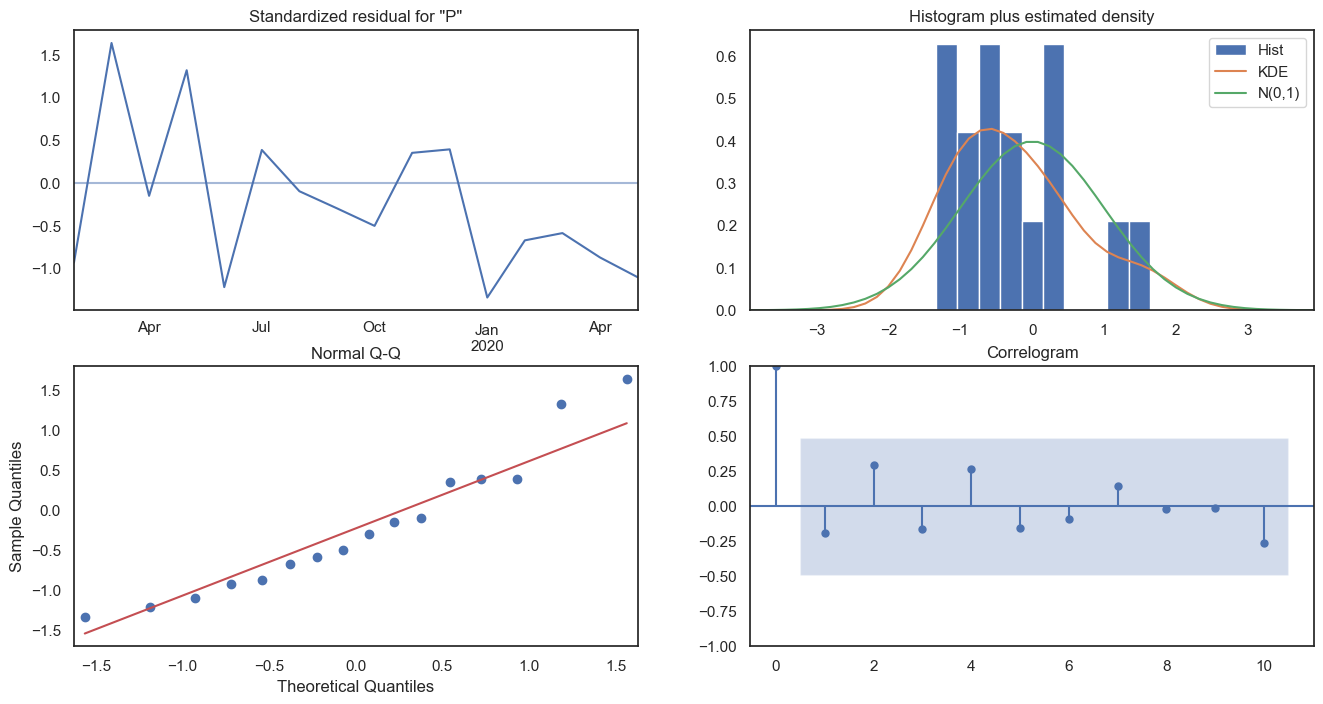

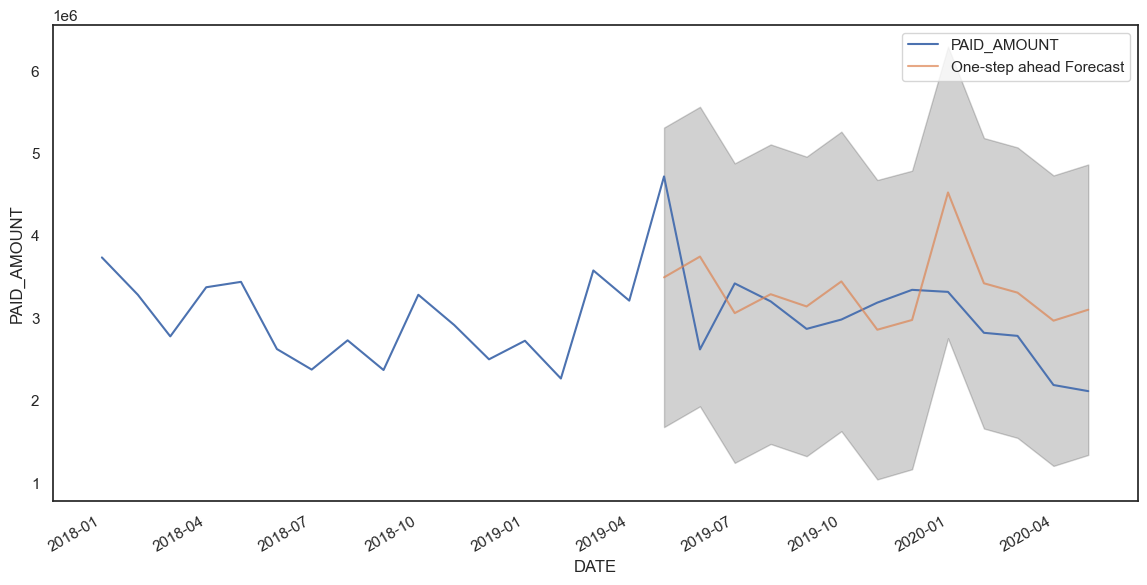

The Mean Squared Error of our forecasts is 547667680890.75
The Root Mean Squared Error of our forecasts is 740045.73


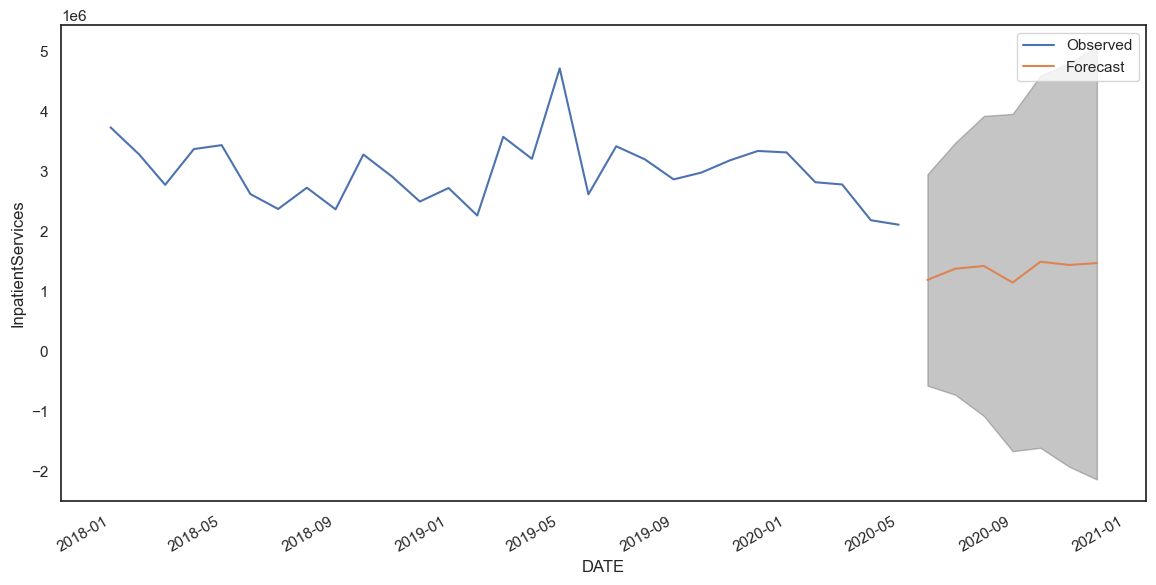

OutpatientServices ((1, 1, 0), (0, 1, 1, 12), 441.80481436035217)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5788      0.521     -1.112      0.266      -1.599       0.441
ma.S.L12      -0.6543      0.694     -0.942      0.346      -2.015       0.706
sigma2      5.003e+10   1.27e-11   3.95e+21      0.000       5e+10       5e+10


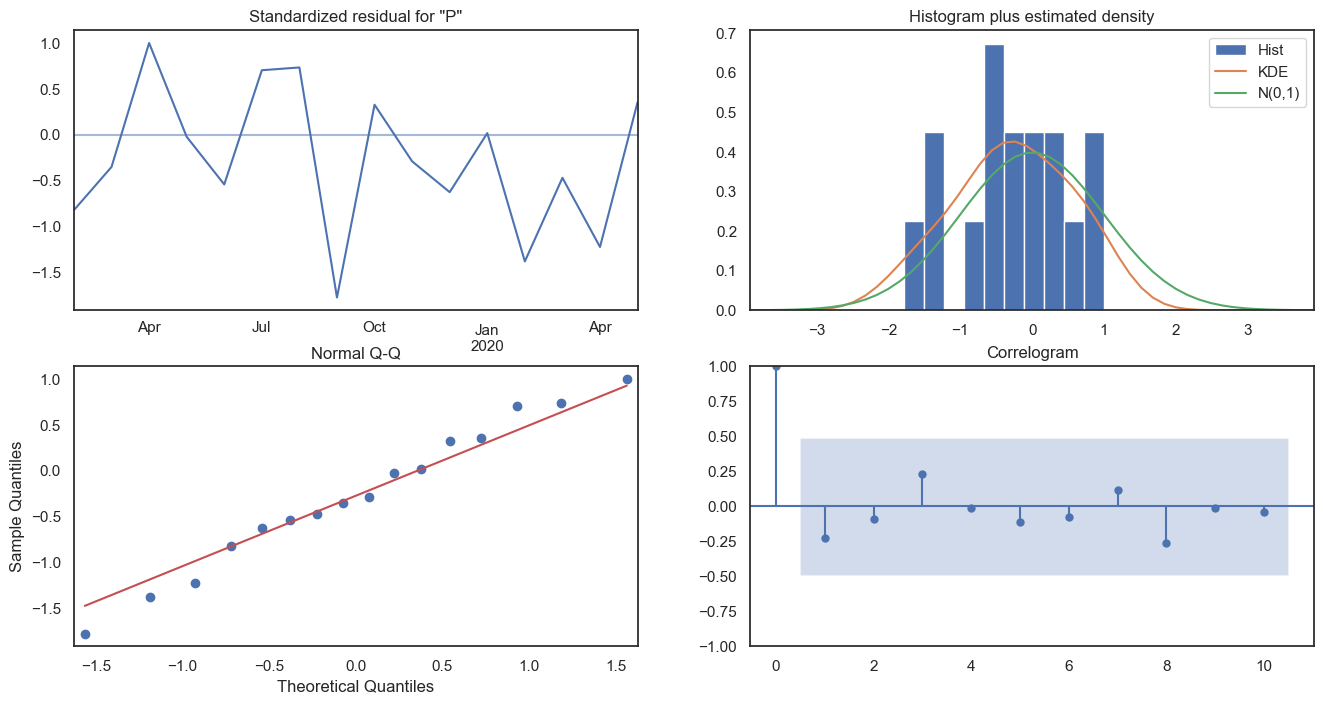

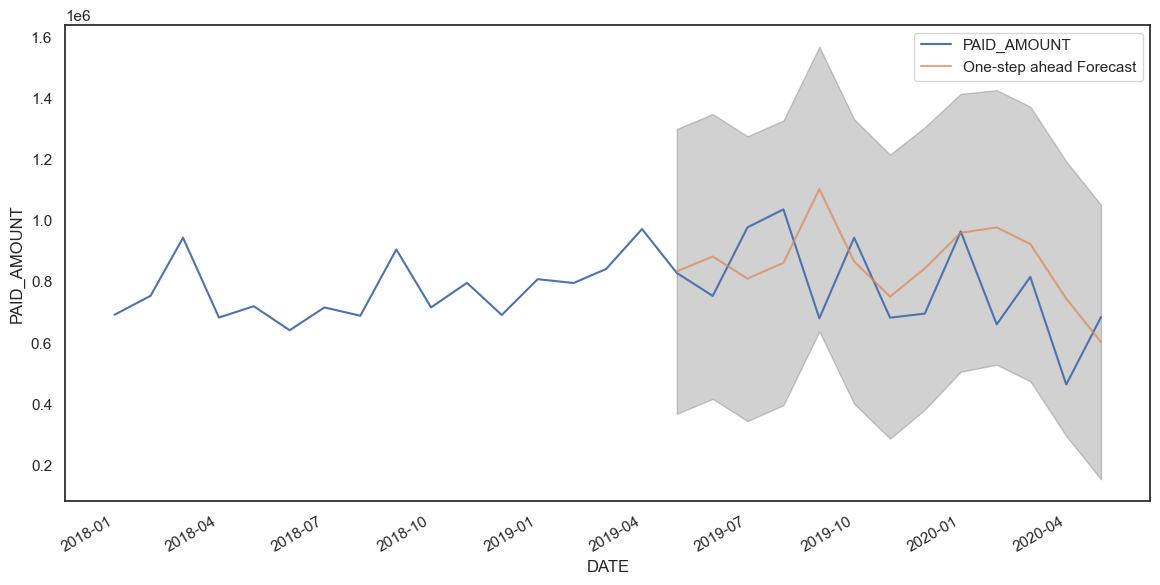

The Mean Squared Error of our forecasts is 37237470203.0
The Root Mean Squared Error of our forecasts is 192970.13


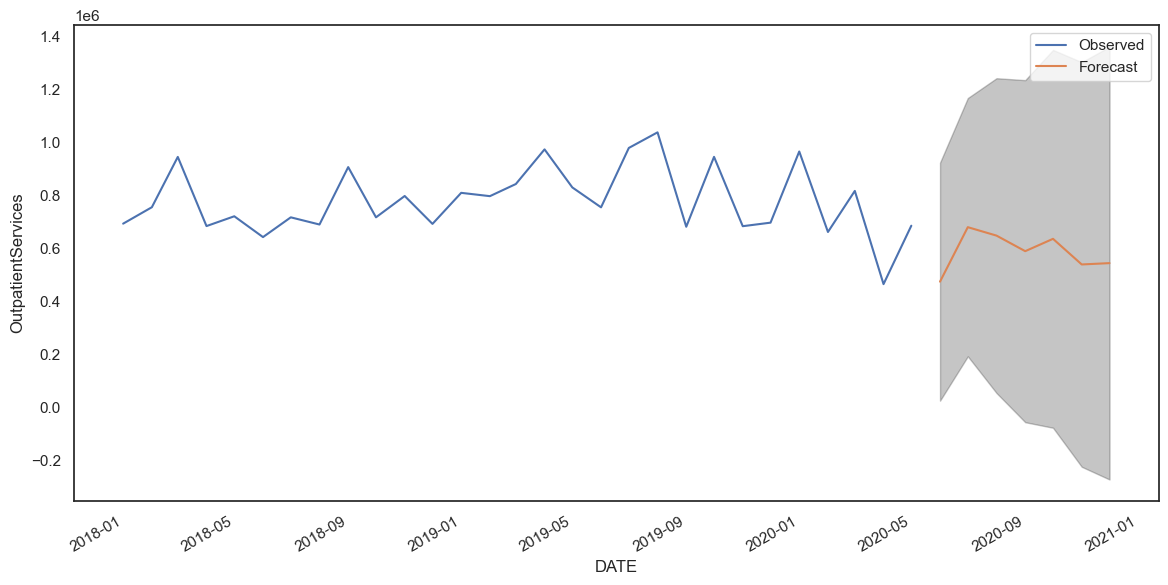

PCPFFS ((1, 1, 0), (0, 1, 0, 12), 365.5423626741807)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2386      0.139     -1.713      0.087      -0.511       0.034
sigma2      3.522e+08   7.29e-12   4.83e+19      0.000    3.52e+08    3.52e+08


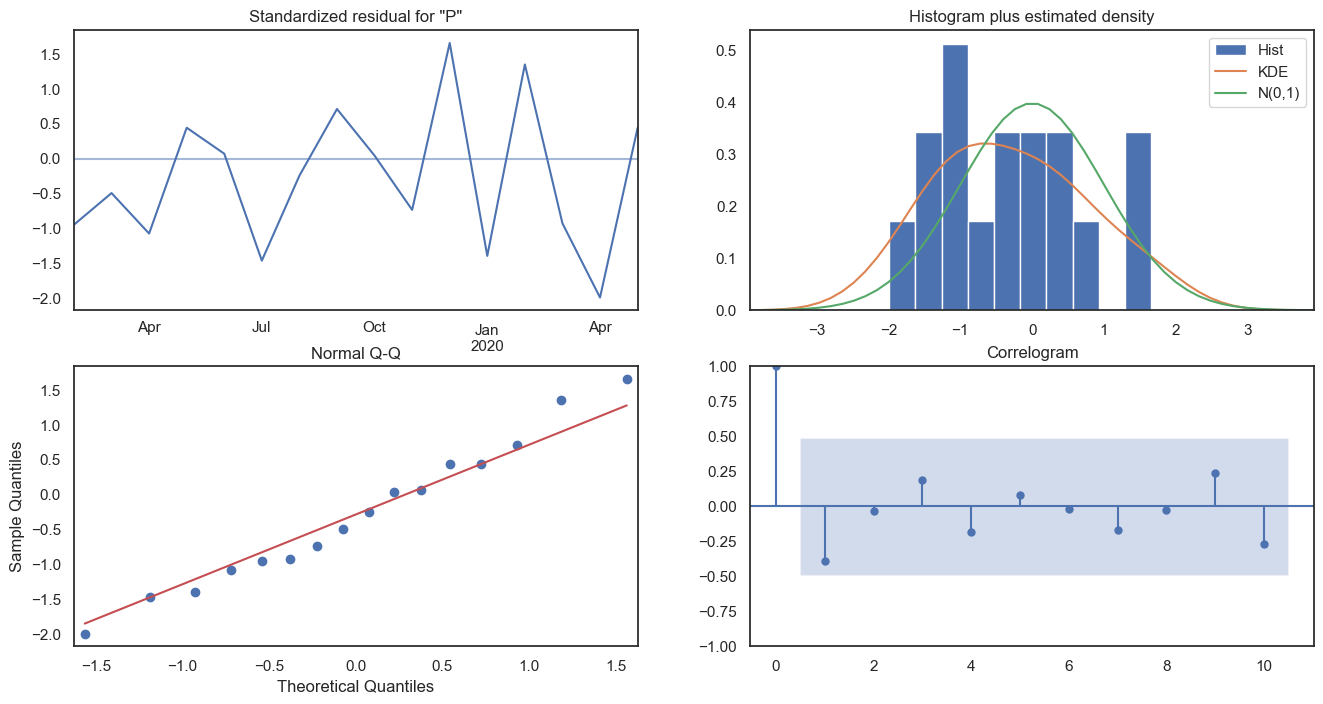

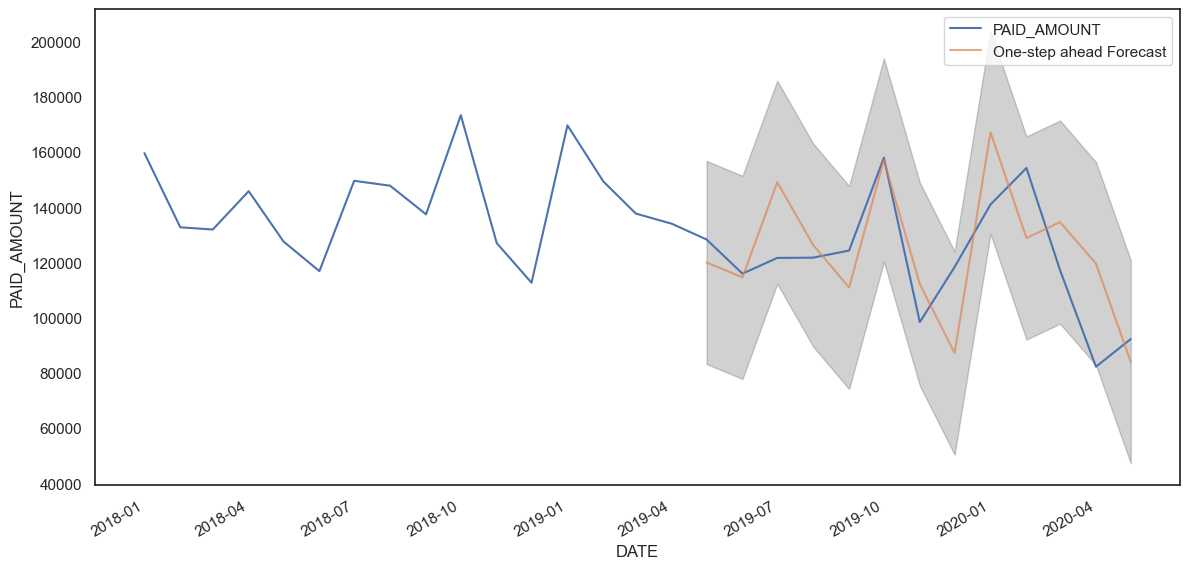

The Mean Squared Error of our forecasts is 405615600.06
The Root Mean Squared Error of our forecasts is 20139.9


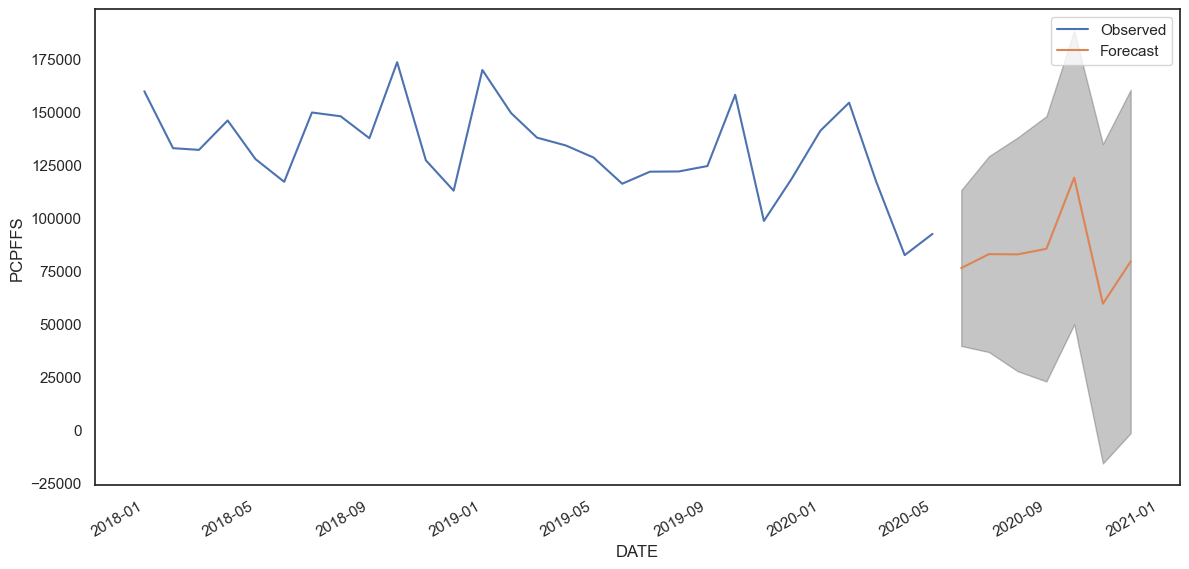

SNFServices ((0, 1, 0), (0, 1, 1, 12), 403.7943715786714)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6006      0.701     -0.857      0.391      -1.974       0.773
sigma2      6.142e+09   1.03e-10   5.96e+19      0.000    6.14e+09    6.14e+09


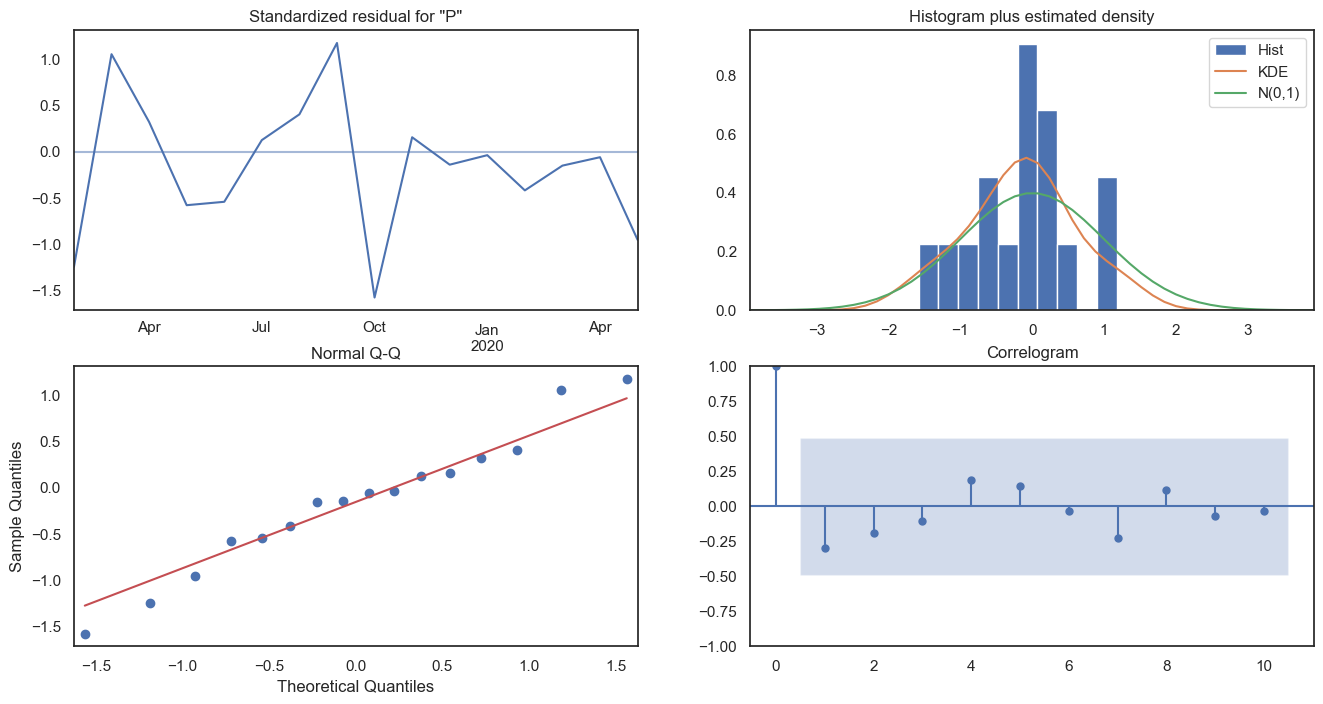

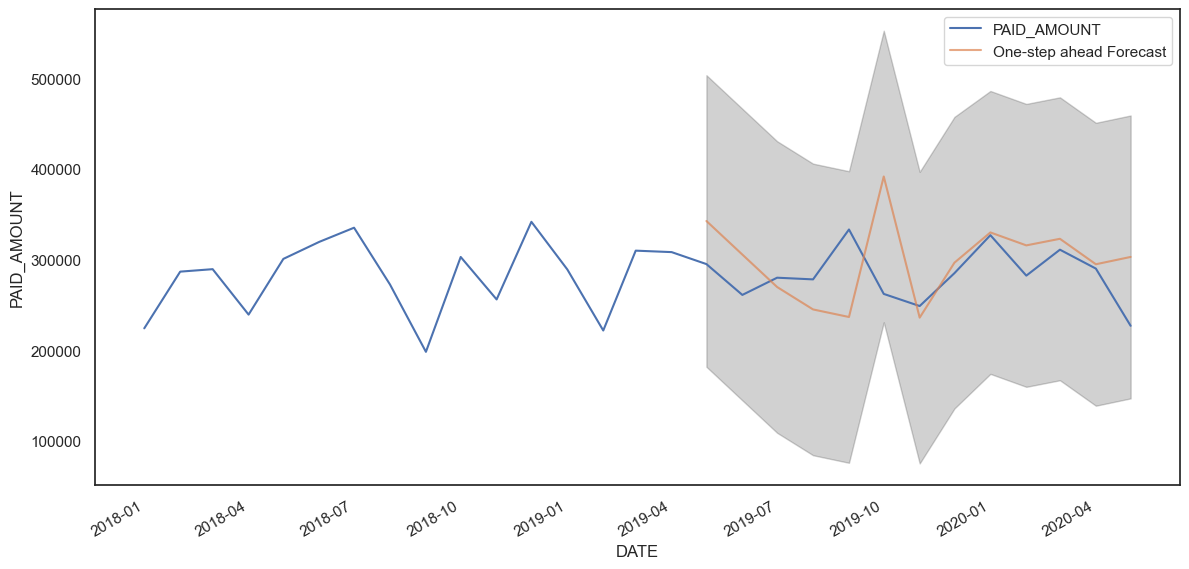

The Mean Squared Error of our forecasts is 2990984608.59
The Root Mean Squared Error of our forecasts is 54689.89


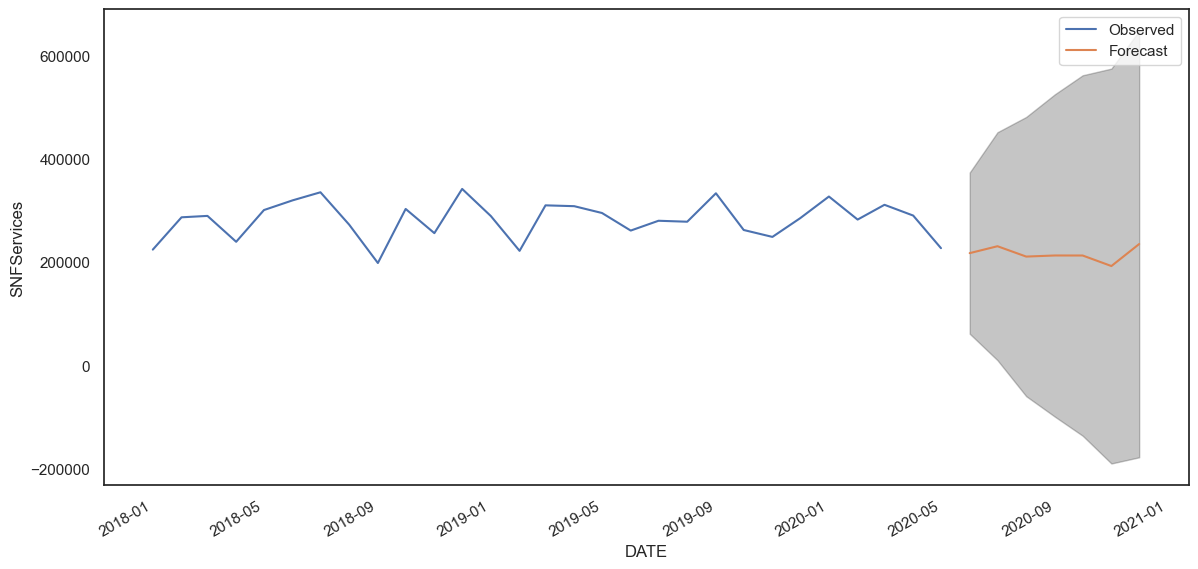

SpecialistFFS ((1, 1, 0), (0, 1, 1, 12), 429.01605886278026)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3149      0.270     -1.165      0.244      -0.844       0.215
ma.S.L12      -0.3512      0.274     -1.283      0.200      -0.888       0.185
sigma2      1.995e+10   9.73e-12   2.05e+21      0.000       2e+10       2e+10


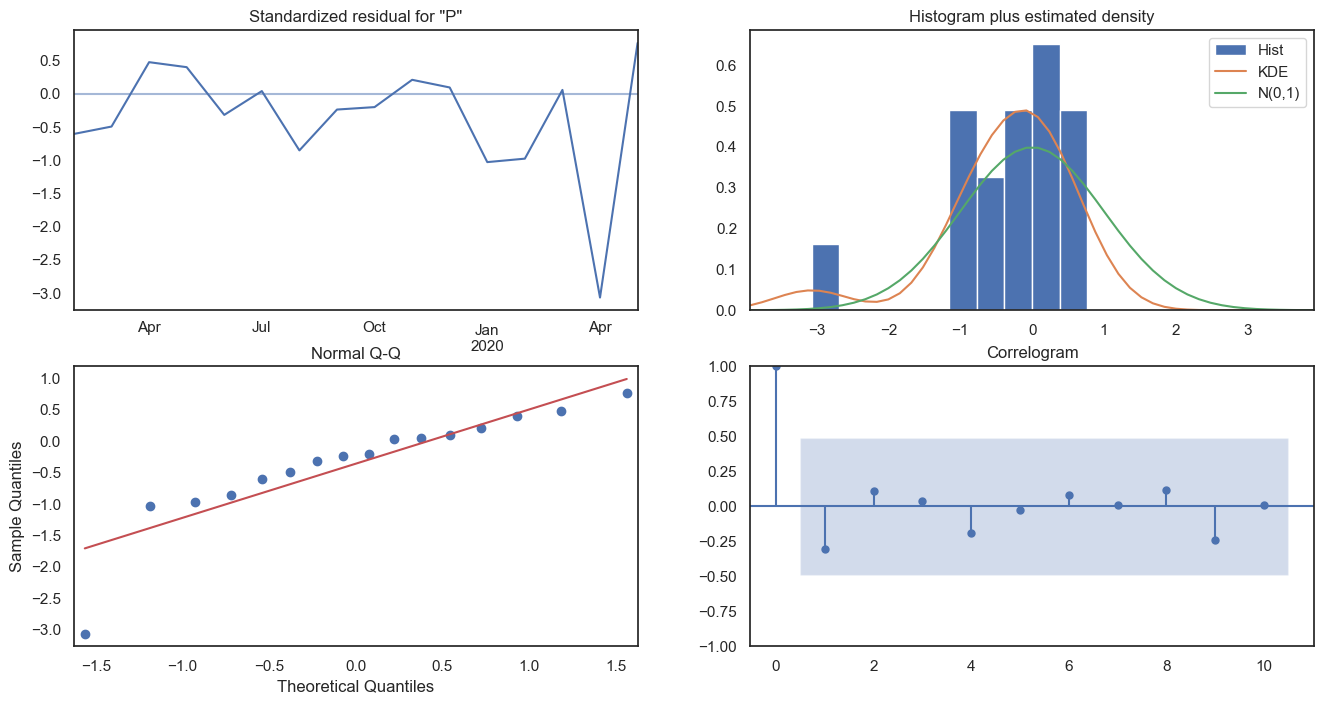

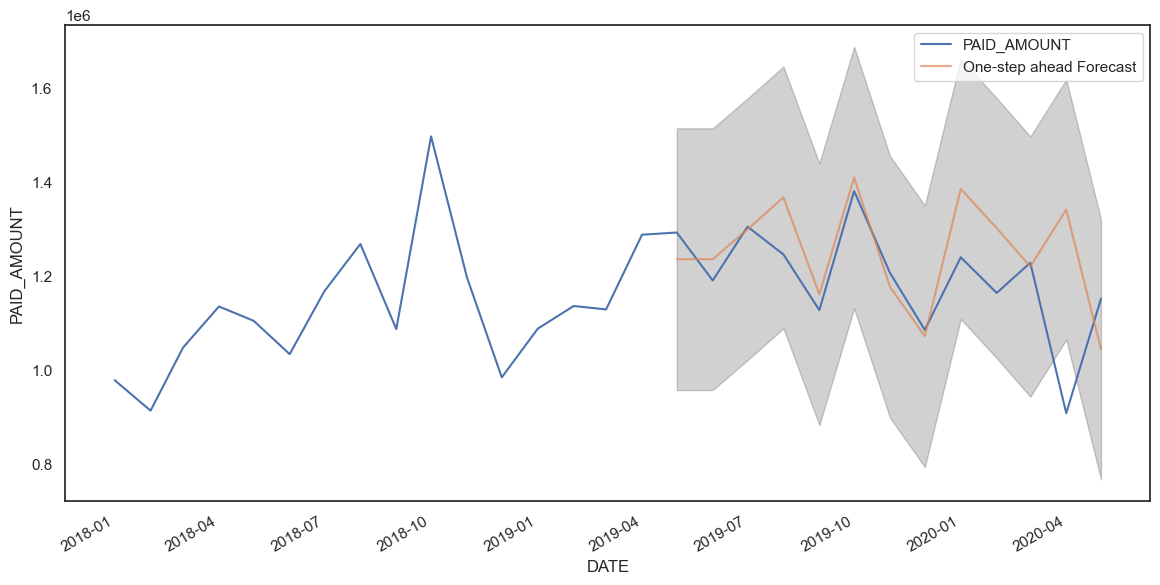

The Mean Squared Error of our forecasts is 20241196262.63
The Root Mean Squared Error of our forecasts is 142271.56


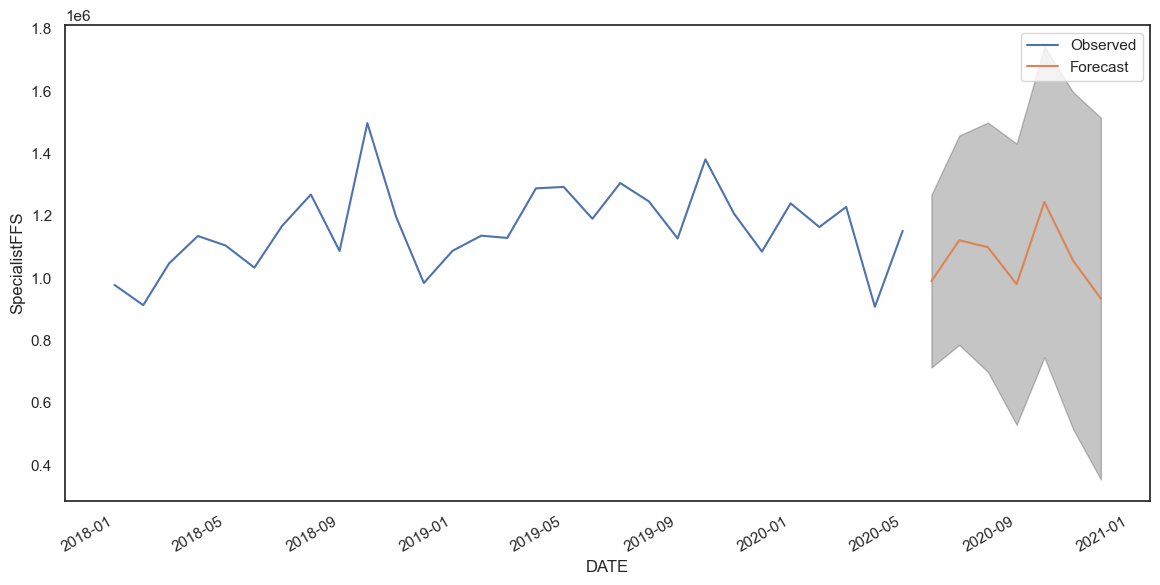

In [34]:
index_dates = ['2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01']
index_dates = pd.to_datetime(index_dates)
predicted_payments = pd.DataFrame(index=index_dates, columns=['predicted_mean'])

for department, value in parameters.items():
    print(department, value)
    payment_by_category_department = payment_by_category[payment_by_category['SERVICE_CATEGORY'] == department]['PAID_AMOUNT']
    mod = sm.tsa.statespace.SARIMAX(payment_by_category_department,
                                order=value[0],
                                seasonal_order=value[1],
                                enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    pred = results.get_prediction(start=pd.to_datetime('2019-05-01'), dynamic=False)
    pred_ci = pred.conf_int()
    ax = payment_by_category_department[pd.Timestamp('2018-01-01').date():].plot(label='PAID_AMOUNT')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('DATE')
    ax.set_ylabel('PAID_AMOUNT')
    plt.legend()
    plt.show()
    y_forecasted = pred.predicted_mean
    y_truth = payment_by_category_department[pd.Timestamp('2019-05-01').date():]
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
    print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))
    pred_uc = results.get_forecast(steps=7)
    pred_ci = pred_uc.conf_int()
    ax = payment_by_category_department.plot(label='Observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('DATE')
    ax.set_ylabel(f'{department}')
    plt.legend()
    plt.show()
    predicted_payments = predicted_payments.add(pd.DataFrame(results.forecast(steps=7)), fill_value=0)

In [35]:
observed_payments = payment_by_category.groupby('DATE')['PAID_AMOUNT'].sum().reset_index()
observed_payments['DATE'] = pd.to_datetime(observed_payments['DATE'])
observed_payments.set_index('DATE', inplace=True)
predicted_payments.columns = observed_payments.columns
result_payments = pd.concat([observed_payments, predicted_payments])
result_payments['PAID_AMOUNT'] = result_payments['PAID_AMOUNT'].astype(float).round()

Let's make vizualization of forecast:
<a name='arima_viz'></a>
###### [Back to top](#summary)

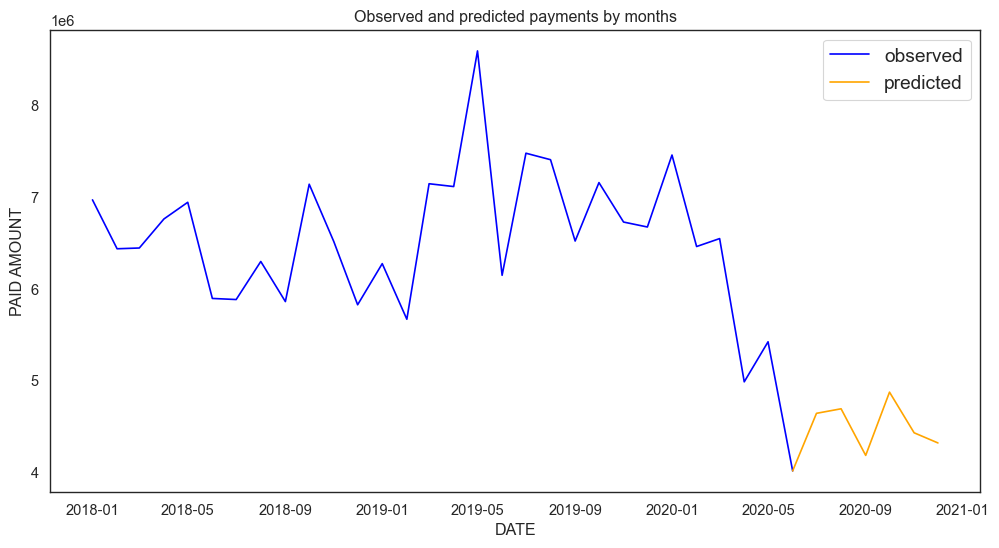

In [36]:
observed = result_payments[result_payments.index < pd.to_datetime('2020-07-01')]
predicted = result_payments[result_payments.index >= '2020-06-01']
plt.figure(figsize=(12, 6))
sns.set_context('paper', font_scale=1.2)
sns.lineplot(x=observed.index, y=observed['PAID_AMOUNT'], color='blue', label='observed')
sns.lineplot(x=predicted.index, y=predicted['PAID_AMOUNT'], color='orange', label='predicted')
plt.title('Observed and predicted payments by months')
plt.xlabel('DATE')
plt.ylabel('PAID AMOUNT')
plt.legend(fontsize='large')
plt.show()